In [1]:
from modAL.models import ActiveLearner
from modAL.uncertainty import uncertainty_sampling
from modAL.pal import probabilistic_al
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

In [2]:
X, y = make_blobs(random_state=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

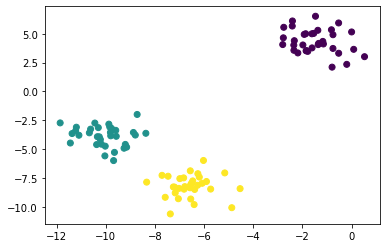

In [3]:
from matplotlib import pyplot as plt
plt.scatter(*X.T, c=y)
plt.show()

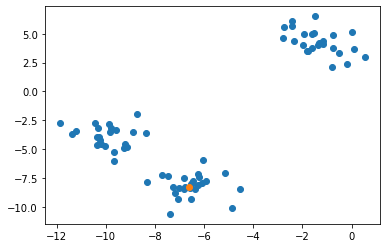

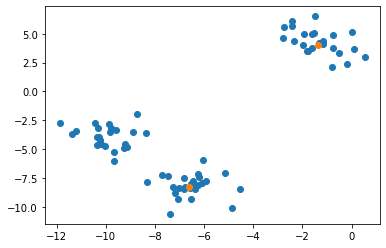

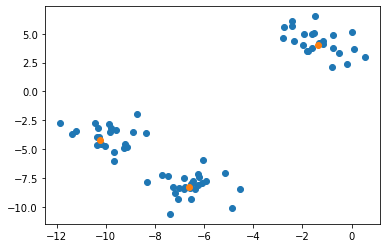

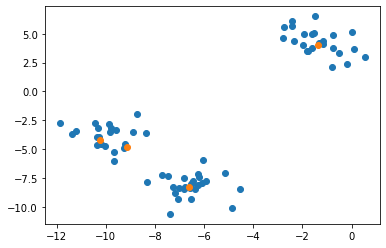

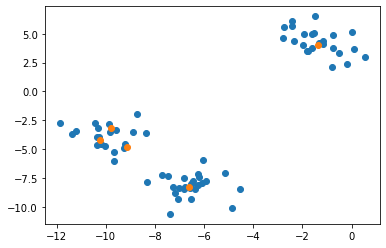

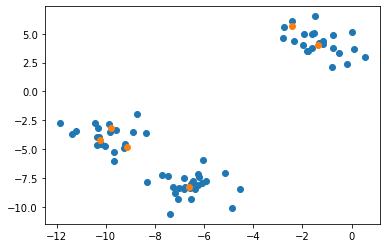

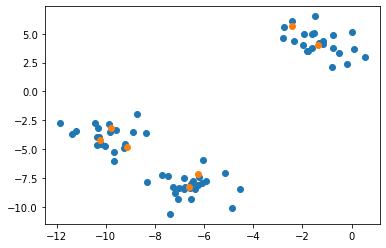

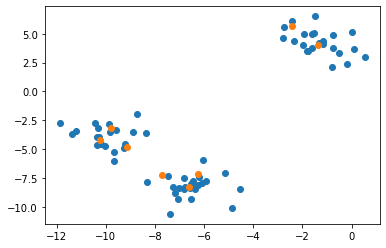

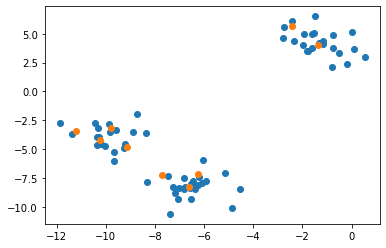

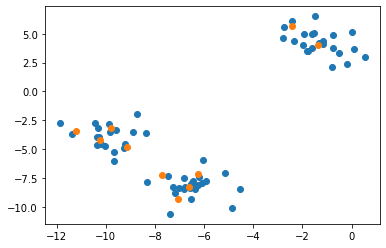

In [4]:
# initializing the learner
X_pool = X_train
y_pool = y_train

selection = lambda classifier, X: uncertainty_sampling(classifier, X, random_tie_break=False)
selection = probabilistic_al
selection = lambda classifier, X: probabilistic_al(classifier, X, prior=0.01)


learner = ActiveLearner(estimator=RandomForestClassifier(), query_strategy=selection)

# query for labels
n_queries = 10
for idx in range(n_queries):
    query_idx, query_instance = learner.query(X_pool)
    learner.teach(
        X=X_pool[query_idx].reshape(1, -1),
        y=y_pool[query_idx].reshape(1, )
    )
    # remove queried instance from pool
    X_pool = np.delete(X_pool, query_idx, axis=0)
    y_pool = np.delete(y_pool, query_idx)
    X_labeled = learner.X_training
    plt.scatter(X_pool[:,0], X_pool[:,1])
    plt.scatter(X_labeled[:,0], X_labeled[:,1])
    plt.show()
#     print('Queried indices:', query_idx)